In [1]:
import numpy as np
from datasets import load_from_disk
import sys
sys.path.append('../')
import os
os.environ["HF_DATASETS_CACHE"]="/shared/.cache/huggingface/dataset"

In [2]:
datasets = load_from_disk('/shared/how2_all_proc') #Just filtered Velocity

In [3]:
from utils.dataset import setup_data
datasets = setup_data('/shared/how2_all_proc', ds_frac=0.1)

Loading cached split indices for dataset at /shared/how2_all_proc/cache-de358b2c5fbf8361.arrow and /shared/how2_all_proc/cache-0dcb19661ebabc7e.arrow


In [4]:
from safetensors.torch import load_model
from model import MFDOOM
from encoders import MultimodalCollator
from torch.utils.data import DataLoader
from utils.config import training_config, get_model_config
output_dir = "/efs-private/multimodal/training_output_19_28_18_01_2024" #Doom
config = training_config(os.path.join(output_dir,'config.yaml'))
model_config = get_model_config(config)
model_config['batch_size']=4

batch_size: 8
clip: 2.0
dataset: /shared/how2_all_proc
dim_head: 64
dropout: 0.1
ds_frac: 0.1
ds_seed: 42
encoder_configs:
  aud:
    max_tokens: 320
    patch_size: [32, 8]
    type: PatchEncoder
  en:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  pt:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  sm:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  vid:
    max_tokens: 2048
    num_embeddings: 2048
    padding_idx: -1
    type: TabularEncoder
epochs: 32
ff_mult: 4
heads: 8
hidden_size: 512
inverse_doom: False
isolate_fusion_tokens: True
layers: 3
lr: 1e-05
lr_scheduler_type: cosine
modality_config:
  aud:
    max_channels: 40
    pad_len: 2048
    type: matrix
  en:
    data_col_name: tokens
    pad_len: 64
    type: sequence
  pt:
    data_col_name: tokens
    pad_len: 64
    type: sequence
  sm:
    data_col_name: tokens
    pad_len: 64
    type: sequence
  vid:
    pad_len: 2048
    type: sequence
modality_c

In [5]:
import model
from importlib import reload
reload(model)
from model import MFDOOM
import matplotlib.pyplot as plt
import torch

In [6]:
default_data_collator = MultimodalCollator(config.modality_config)
#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader = DataLoader(datasets['train'].with_format('torch'), 
                        shuffle=True, 
                        collate_fn=default_data_collator, 
                        batch_size=4,)

In [10]:
model = MFDOOM(**model_config)

Got kwargs: {}
Doing MSE


In [11]:
dl=iter(dataloader)
infer_model = model.eval()
output = [infer_model(next(dl)) for _ in range(2)]

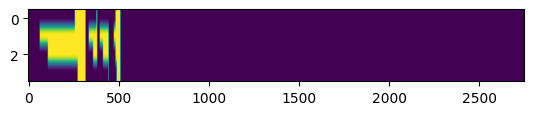

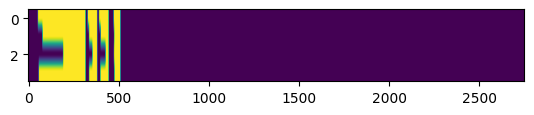

In [12]:
for op in output:
    plt.figure()
    plt.imshow(op[1],aspect=100)

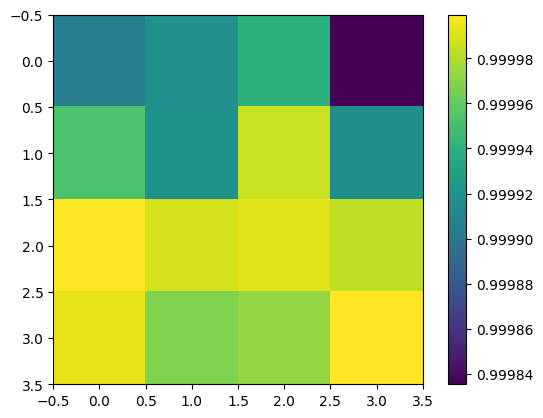

In [21]:
v=output[0][0]['vid']
v2 = output[1][0]['vid']
l = v.shape[0]
cos = torch.nn.CosineSimilarity(dim=0)
mat=np.zeros([l,l])
for i in range(l):
    for j in range(l):
        mat[i,j]=cos(v[i],v2[j])
plt.imshow(mat)
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k] if output2 else output['fusion']
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    f, ax = plt.subplots(len(mat_dict),2, figsize=(6,3*len(mat_dict)))
    for i,(k,mat) in enumerate(mat_dict.items()):
        #f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
        #plt.figure(figsize=(2,2))
        #ax1.title(k)
        ax1 = ax[i,0]
        im = ax1.imshow(mat, vmin=vmin, vmax=vmax)
        ax1.set_ylabel(k)
        f.colorbar(im,ax=ax1)
        if plot_diag:
            #plt.figure(figsize=(2,2))
            #plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            ax2 = ax[i,1]
            ax2.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            ax2.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            ax2.set_ylim(0,50)
            ax2.set_xlim(0,1.0)
            ax2.legend(["diag","all"])

        

In [ ]:
print(output_r.keys())

In [ ]:
bs

In [ ]:
plot_cosines(output_r[('baseline',)],output_r[('baseline',)]) #

In [ ]:
plot_cosines(output_r[('baseline',)],  output_r[('vid',)])#,vmin=0.75)
# Weight fusion losses by number of tokens?

# Attention masking tests

In [ ]:
plt.imshow(model.pool_mask, aspect=100)
plt.colorbar()

In [ ]:
t=torch.load('../batch.pt', map_location=torch.device('cpu'))
p=torch.load('../padding_mask.pt', map_location=torch.device('cpu'))
a = torch.load('../attn_mask.pt', map_location=torch.device('cpu'))

In [ ]:
plt.plot(p[0,:])
plt.figure()
plt.plot(p[1,:])
plt.figure()
plt.plot(p[4,:])

In [ ]:
plt.imshow(a)

In [ ]:
print(t.isnan().reshape((-1,t.shape[1]*t.shape[2]))
      .shape)
plt.imshow(torch.cat([t.isnan()[i,:,:] for i in range(8)], dim=1))
plt.colorbar()

In [ ]:
plt.imshow(model.attn_mask)

In [ ]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [ ]:
token_types.shape

In [ ]:
from einops import rearrange, repeat

In [ ]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [ ]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [ ]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

In [ ]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

In [ ]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

In [ ]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
torch.empty(0)

In [ ]:
batch

In [ ]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [ ]:
return_tokens.shape

In [ ]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

In [ ]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

In [ ]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

In [ ]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

In [ ]:
plt.plot(pool_mask.T)

In [ ]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

In [ ]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [ ]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

In [ ]:
sim

# Combine datasets

In [ ]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [ ]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [ ]:
len(shuffled_dataset)

In [ ]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [ ]:
import torch

In [ ]:
t = torch.zeros(10)

In [ ]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [ ]:
t

In [ ]:
    f, ax= plt.subplots(4,2, figsize=(6,2))


In [ ]:
ax

In [ ]:
import datasets
!ls /shared
dataset = datasets.load_from_disk('/shared/how2_all_proc')

In [ ]:
dataset[0]['vid']

In [ ]:
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

In [ ]:
x = torch.Tensor([[0,1,1,1],[0,1,1,0]])

In [ ]:
x

In [ ]:
x.swapaxes(0,1)

In [36]:
from encoders import PositionalEncoder, TokenEncoder

In [57]:
pe = PositionalEncoder(256)
te = TokenEncoder(12,256)

In [58]:
pe

PositionalEncoder(
  (dropout): Dropout(p=0.1, inplace=False)
)

In [59]:
batch={'tokens':torch.randint(10,(16,128)),'attention_mask':None}

torch.Size([16, 128, 256])


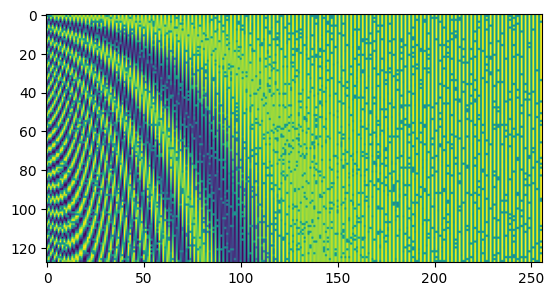

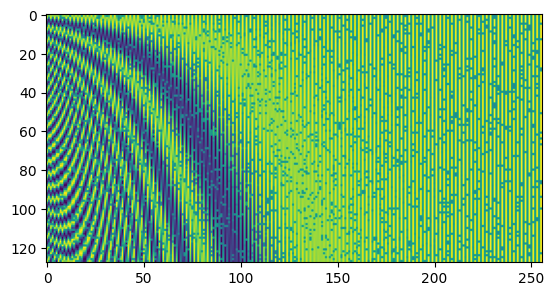

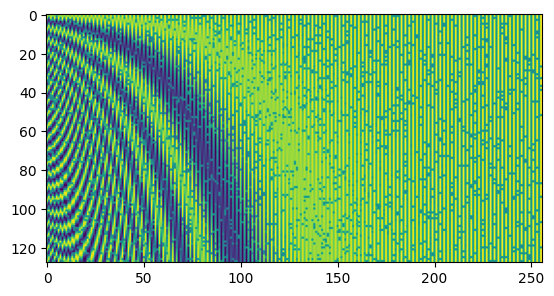

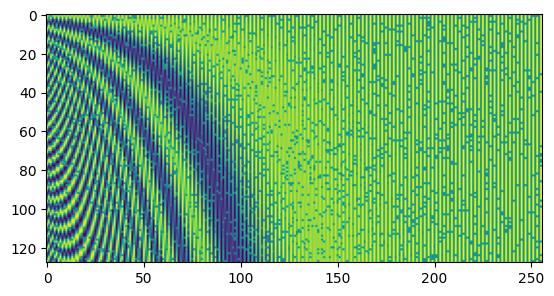

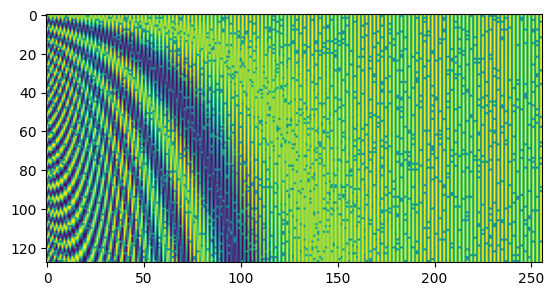

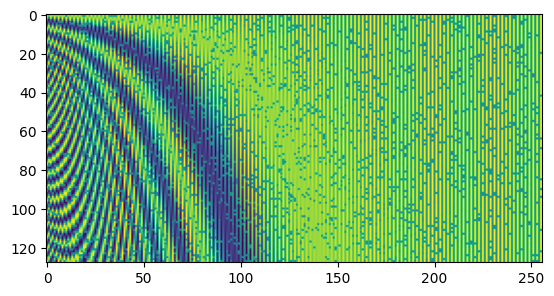

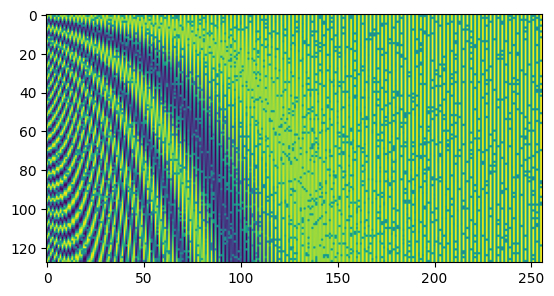

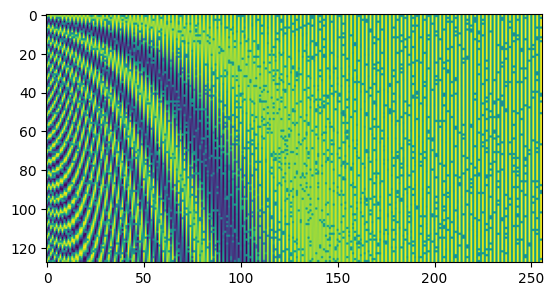

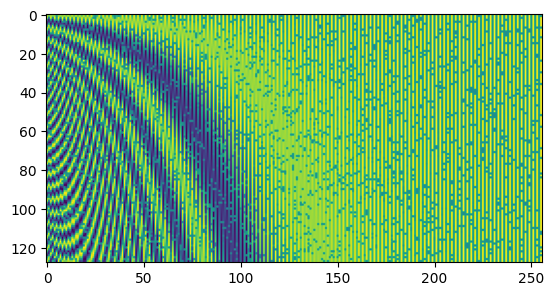

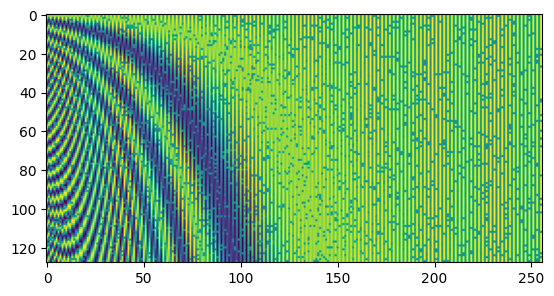

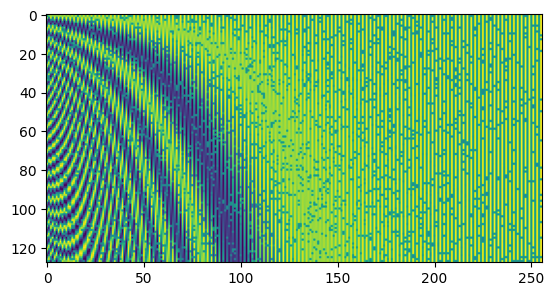

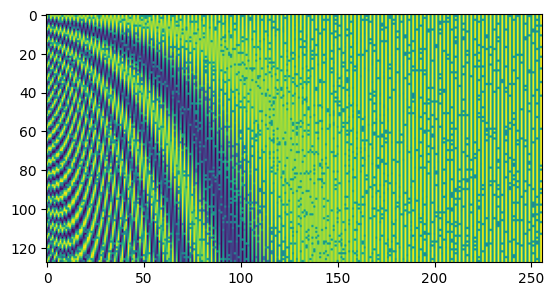

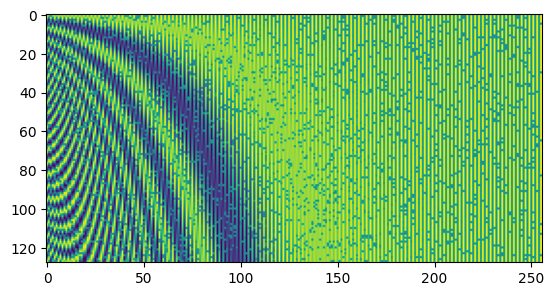

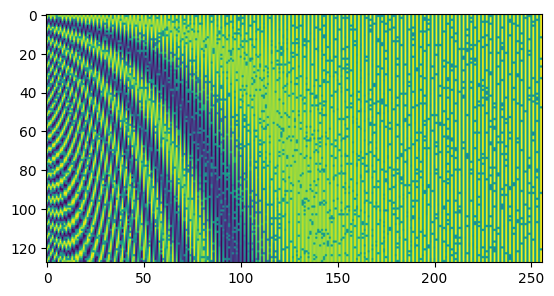

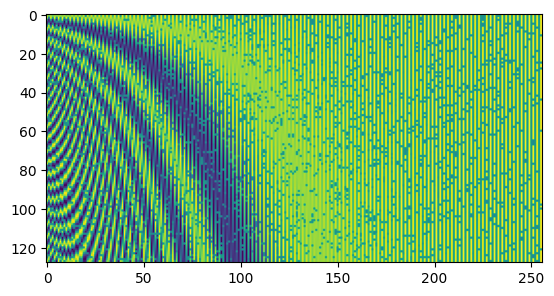

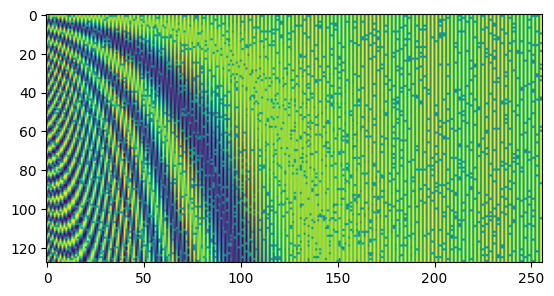

In [61]:
p = pe(batch['tokens'])
print(p.shape)
for i in range(p.shape[0]):
    plt.figure()
    plt.imshow(p[i])

In [41]:
te(batch['tokens']).shape

torch.Size([16, 128, 256])

In [56]:
from torch import nn, Tensor
import math
class PositionalEncoder(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 2048,  **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        return self.dropout(self.pe[: x.size(1)].repeat(x.size(0),1,1))

In [1]:
import torch

In [36]:
x=torch.randn([4,4,8])
y = torch.zeros([4,4]).to(torch.bool)
y[0,:2]=1
y[1,:1]=1
y[2,:2]=1
y[3,:3]=1
#y=y.unsqueeze(-1).repeat(1,1,8)
print(y.shape)
print(x.shape)
y#=(~y).nonzero()


torch.Size([4, 4])
torch.Size([4, 4, 8])


tensor([[ True,  True, False, False],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False]])

In [37]:
x.masked_fill(~y.to(torch.bool),0.0)

RuntimeError: The size of tensor a (4) must match the size of tensor b (8) at non-singleton dimension 2

In [15]:
x.shape

torch.Size([4, 4, 8])

In [ ]:
!ls

In [9]:
import torch
#model = torch.load('../model.pt')
batch = torch.load('../batch.pt', map_location='cpu')
a_batch = torch.load('../a_batch.pt', map_location='cpu')

In [10]:
batch

{'COVAREP': {'attention_mask': tensor([[False, False, False,  ..., False, False, False],
          [False, False, False,  ...,  True,  True,  True]]),
  'tokens': tensor([[[121.5000,   1.0000,   0.2243,  ...,  -0.3878,  -0.2728,  -0.2117],
           [122.5000,   1.0000,   0.1578,  ...,  -0.3899,  -0.2894,  -0.2324],
           [123.0000,   1.0000,   0.1311,  ...,  -0.3935,  -0.3079,  -0.2576],
           ...,
           [ 89.5000,   0.0000,   0.1941,  ...,  -0.4353,  -0.3924,  -0.3647],
           [ 90.0000,   0.0000,   0.1907,  ...,  -0.4279,  -0.3994,  -0.3537],
           [ 88.0000,   0.0000,   0.1872,  ...,  -0.4217,  -0.4068,  -0.3446]],
  
          [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           ...,
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 

In [15]:
import datasets
ds = datasets.load_from_disk('/shared/cmu')

Loading dataset from disk:   0%|          | 0/48 [00:00<?, ?it/s]

In [37]:
ds['COVAREP']


KeyboardInterrupt



In [31]:
mins, maxs, means = [], [], []
for sample in ds:
    s = sample['FACET']['data']
    #print(s)
    if s.isinf().sum():
        print(s.isinf().sum())
        s[s.isinf()]=0
    mins.append(s.min())
        
        
    maxs.append(s.max())
    means.append(s.mean())

KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt

(array([   6.,   35.,  115.,  422.,  766., 1019., 1126., 1169.,  638.,
          35.]),
 array([-37.1119 , -33.40071, -29.68952, -25.97833, -22.26714, -18.55595,
        -14.84476, -11.13357,  -7.42238,  -3.71119,   0.     ],
       dtype=float32),
 <BarContainer object of 10 artists>)

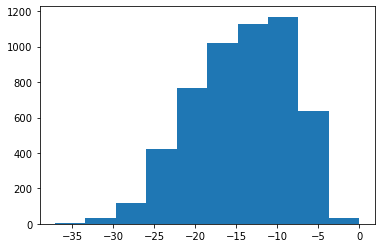

In [36]:
plt.hist(mins)

In [ ]:
FACET: -30:30